In [19]:
###################################################################################
# DEFINITION FUNCTION FOR CONVERTING FILES INTO DESIRED DATA COLUMNS
###################################################################################

from astropy.io import ascii 
from astropy.table import Table
from astropy.table import Column
import matplotlib.gridspec as gridspec
import numpy as np 
import coronagraph as cg
import matplotlib.pyplot as plt
import math
import os, glob
import copy
import collections
import pandas as pd
import matplotlib.font_manager as font_manager

os.chdir('/Users/schuylerraeschroerborges/Desktop/Second_Project/')

def newcols(data):
    columnone=[]
    columntwo=[]
    columnfour=[]
    columnthree=[]
    if data.endswith('.rad'):
        clear = ascii.read(data, data_start=0,  delimiter='\s')
        for i in range (0,len(clear)):
            columnone.append(float(clear[i][0]))
            columnfour.append(float(clear[i][3]))
            columnthree.append(float(clear[i][2]))
        wave=np.array(columnone)
        rad=np.array(columnfour)
        flux=np.array(columnthree)
    
        reflect=np.divide(rad,flux)        
    else:
        cloudy = ascii.read(data, data_start=0,  delimiter='\s')
        for i in range (0,len(cloudy)):
            columnone.append(float(cloudy[i][0]))
            columntwo.append(float(cloudy[i][1]))
            columnthree.append(float(cloudy[i][2]))
            columnfour.append(float(cloudy[i][3]))
        wave=np.array(columnone)
        flux=np.array(columntwo)
        reflect=np.array(columnthree)
        rad=np.array(columnfour)

        

    
    
    return np.array([wave,flux,rad,reflect])

In [21]:
###################################################################################
# FINDING DT FOR 50 DIFFERENT DISTANCES FOR ALL MODELS
###################################################################################

file_list = (['Arthro_clearSky_mon_toa.rad', 'Arthro_clearSky_scrubbed_updated_mon_toa.rad', \
              'Arthro_mixed25.txt', 'Arthro_mixed25_scrubbed.txt', 'Arthro_mixed50.txt', \
              'Arthro_mixed50_scrubbed.txt', 'Arthro_mixed75.txt', 'Arthro_mixed75_scrubbed.txt',\
              'Ecto_clearSky_new_toa.rad', 'Ectoth_clearSky_scrubbed_mon_toa.rad', 'Ectoth_mixed25.txt',\
              'Ectoth_mixed25_scrubbed.txt', 'Ectoth_mixed50.txt', 'Ectoth_mixed50_scrubbed.txt',\
              'Ectoth_mixed75.txt', 'Ectoth_mixed75_scrubbed.txt', 'black_clearSky_mon_toa.rad',\
              'black_clearSky_scrubbed_mon_toa.rad', 'blackmat_mixed25.txt', 'blackmat_mixed25_scrubbed.txt',\
              'blackmat_mixed50.txt', 'blackmat_mixed50_scrubbed.txt', 'blackmat_mixed75.txt',\
              'blackmat_mixed75_scrubbed.txt', 'orangemat_clearSky_mon_toa.rad',\
              'orangemat_clearSky_scrubbed_mon_toa.rad', 'orangemat_mixed25.txt', 'orangemat_mixed25_scrubbed.txt',\
              'orangemat_mixed50.txt', 'orangemat_mixed50_scrubbed.txt', 'orangemat_mixed75.txt',\
              'orangemat_mixed75_scrubbed.txt'])

low_water_list = (['Arthro_clearSky_low_water_mon_toa.rad', 'Arthro_clearSky_low_water_scrubbed_mon_toa.rad',\
                   'Ectoth_um_clearSky_low_water_mon_toa.rad', 'Ectoth_um_clearSky_scrubbed_low_water_mon_toa.rad', \
                   'black_clearSky_low_water_mon_toa.rad', 'black_clearSky_low_water_scrubbed_mon_toa.rad', \
                   'orange_clearsky_low_water_mon_toa.rad', 'orange_scrubbed_clearSky_low_water_mon_toa.rad'])

outfile = "Low_Water_DetectionTimes_distances_IWA_2.txt"
f = open(outfile, 'w')


def distance_noise_model(lamhr, AX_refhr, AY_refhr, AX_solhr, AY_solhr, x_file, y_file):
    distances = np.arange(5, 15.2, 0.2)
    for distance in distances:
        planet = cg.Planet()
    
        # Planet params
        planet.alpha = 90.     # phase angle at quadrature
        planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
        planet.Rp    = 1.0     # Earth radii
        planet.a     = 1.0     # semi-major axis (AU)

        # Stellar params
        star = cg.Star()
        star.Teff  = 5780.   # Sun-like Teff (K)
        star.Rs    = 1.      # star radius in solar radii
    

        # Planetary system params
        planet.distance = distance    # distance to system (pc)
        planet.Nez  = 1.      # number of exo-zodis

        telescope = cg.Telescope()

        # Set paramaters for luvex
        telescope.diameter = 6.0
        telescope.contrast = 1e-10
        telescope.A_collect = 36.
        telescope.diam_inscribed = 6.0
        telescope.Tsys = 270.
        telescope.OWA = 24.
        telescope.IWA = 2.
        telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
        telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
        telescope.emis = 0.7
        telescope.Dtmax = 1.0e3/3600
        telescope.X = .61

        # Visible channel parameters:
        telescope.resolution = 140.
        telescope.throughput = 0.15
        telescope.darkcurrent = 3e-5
        telescope.readnoise = 0.0
        telescope.lammin = 0.4
        telescope.lammax = 1.030
    
    
        # Running the different coronagraph object to run count rates for AX and AY
        noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
        noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
        # running count rates to calculate Dt
        noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
        noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)
    
###################################################################################
# CALCULATING DT
###################################################################################

        # calculating sum of wavelength then using that to divide SN^2 to calculate Dt. (Gialluca et al 2021 equation 9)
        SN = 5.

        sumWav = 0
        i=0
    
        for i in range(len(noise_AX.A)):
            sumWav = sumWav + (( noise_AX.cp[i]**2 * ( noise_AX.A[i] - noise_AY.A[i] )**2 )/( noise_AX.cp[i] + 2*noise_AX.cb[i] ))

        Dts = SN**2/(sumWav)

        Dt = Dts/3600
        print(Dt) 

        print("Done" + str(i) + "\n")
    
        string = str(x_file) + "  " + str(y_file) + "  " +  str(distance) + "  " + "      %g" % (Dt)
        f.write(string + "\n")
    return f.write(string + "\n")


for i in np.arange(0, len(low_water_list), 2):
    ax_file = low_water_list[i]
    ay_file = low_water_list[i+1]
    AX_data = newcols(ax_file)
    AY_data = newcols(ay_file)

    lam = np.array(AX_data[0])    # Lambda
    AX_sol = np.array(AX_data[1])    # Solar flux AX 
    AX_rad = np.array(AX_data[2])    # radiance AX
    AX_ref = np.array(AX_data[3])    # Reflectance of AX

    AY_sol = np.array(AY_data[1])    # Solar flux AY
    AY_rad = np.array(AY_data[2])    # radiance AY
    AY_ref = np.array(AY_data[3])    # Reflectance of AY
    
    distance_noise_model(lam, AX_ref, AY_ref, AX_sol, AY_sol, ax_file, ay_file)
    
    
f.close()
    


10.605372141357165
Done133

11.669946757192545
Done133

12.808021763513352
Done133

14.023245364012752
Done133

15.319401803386832
Done133

16.700411381705365
Done133

18.17033047759885
Done133

19.733351578790362
Done133

21.39380331859451
Done133

23.156150517114078
Done133

25.024994225982002
Done133

27.005071775616674
Done133

29.101256824080856
Done133

31.31855940675116
Done133

33.66212598611909
Done133

36.13723950114987
Done133

38.74931941572326
Done133

41.50392176576939
Done133

44.40673920479342
Done133

47.463601047552736
Done133

50.680473311714
Done133

54.06345875737087
Done133

57.61879692434898
Done133

61.35286416726475
Done133

65.27217368833746
Done133

69.38337556797994
Done133

73.69325679321466
Done133

78.20874128398162
Done133

82.93688991741321
Done133

87.88490055016572
Done133

93.0601080389004
Done133

98.46998425901187
Done133

104.12213812170664
Done133

110.02431558953218
Done133

116.18439969045487
Done133

122.61041053059019
Done133

129.31050530567

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/coronagraph/count_rates.py:314: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/coronagraph/count_rates.py:315: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt


234.24657347626814
Done133

245.31445470242414
Done133

256.78501916913046
Done133

30.67700139351188
Done133

33.99817119045321
Done133

37.57709403984444
Done133

41.42799679984227
Done133

45.56560330602316
Done133

50.005135986080745
Done133

54.76231754976001
Done133

59.85337271539677
Done133

65.29502994132301
Done133

71.10452313657288
Done133

77.2995933307497
Done133

83.89849028761722
Done133

90.91997405099124
Done133

98.38331641489147
Done133

106.30830231271922
Done133

114.71523112253574
Done133

123.624917887371
Done133

133.05869445097537
Done133

143.03841051057663
Done133

153.5864345890839
Done133

164.7256549298271
Done133

176.47948031737906
Done133

188.87184082831192
Done133

201.92718851591303
Done133

215.67049803297326
Done133

230.12726719674254
Done133

245.3235175001056
Done133

261.2857945729063
Done133

278.0411685972147
Done133

295.6172346801626
Done133

314.0421131877913
Done133

333.34445004316234
Done133

353.55341699178183
Done133

374.69871183720

In [11]:
###################################################################################
# FINDING DT FOR 50 DIFFERENT DISTANCES FOR ALL MODELS
###################################################################################

file_list = (['Arthro_clearSky_mon_toa.rad', 'Arthro_clearSky_scrub_v3_um_toa.rad', \
              'Arthro_mixed25.txt', 'Arthro_new_mixed25_scrubbed.txt', 'Arthro_mixed50.txt', \
              'Arthro_new_mixed50_scrubbed.txt', 'Arthro_mixed75.txt', 'Arthro_new_mixed75_scrubbed.txt',\
              'Ecto_clearSky_new_toa.rad', 'Ectoth_clearSky_scrubbed_mon_toa.rad', 'Ectoth_mixed25.txt',\
              'Ectoth_mixed25_scrubbed.txt', 'Ectoth_mixed50.txt', 'Ectoth_mixed50_scrubbed.txt',\
              'Ectoth_mixed75.txt', 'Ectoth_mixed75_scrubbed.txt', 'black_clearSky_mon_toa.rad',\
              'black_clearSky_scrubbed_mon_toa.rad', 'blackmat_mixed25.txt', 'blackmat_mixed25_scrubbed.txt',\
              'blackmat_mixed50.txt', 'blackmat_mixed50_scrubbed.txt', 'blackmat_mixed75.txt',\
              'blackmat_mixed75_scrubbed.txt', 'orangemat_clearSky_mon_toa.rad',\
              'orangemat_clearSky_scrubbed_mon_toa.rad', 'orangemat_mixed25.txt', 'orangemat_mixed25_scrubbed.txt',\
              'orangemat_mixed50.txt', 'orangemat_mixed50_scrubbed.txt', 'orangemat_mixed75.txt',\
              'orangemat_mixed75_scrubbed.txt'])

low_water_list = (['Arthro_clearSky_low_water_mon_toa.rad', 'Arthro_scrubbed_v3_clearSky_new_lowh2o_toa.rad',\
                   'Ectoth_um_clearSky_low_water_mon_toa.rad', 'Ectoth_um_clearSky_scrubbed_low_water_mon_toa.rad', \
                   'black_clearSky_low_water_mon_toa.rad', 'black_clearSky_low_water_scrubbed_mon_toa.rad', \
                   'orange_clearsky_low_water_mon_toa.rad', 'orange_scrubbed_clearSky_low_water_mon_toa.rad'])

outfile = "DetectionTimes_new_arthro_scrub_distances_IWA_2.5.txt"
f = open(outfile, 'w')


def distance_noise_model(lamhr, AX_refhr, AY_refhr, AX_solhr, AY_solhr, x_file, y_file):
    distances = np.arange(5, 15.2, 0.2)
    for distance in distances:
        planet = cg.Planet()
    
        # Planet params
        planet.alpha = 90.     # phase angle at quadrature
        planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
        planet.Rp    = 1.0     # Earth radii
        planet.a     = 1.0     # semi-major axis (AU)

        # Stellar params
        star = cg.Star()
        star.Teff  = 5780.   # Sun-like Teff (K)
        star.Rs    = 1.      # star radius in solar radii
    

        # Planetary system params
        planet.distance = distance    # distance to system (pc)
        planet.Nez  = 1.      # number of exo-zodis

        telescope = cg.Telescope()

        # Set paramaters for luvex
        telescope.diameter = 6.0
        telescope.contrast = 1e-10
        telescope.A_collect = 36.
        telescope.diam_inscribed = 6.0
        telescope.Tsys = 270.
        telescope.OWA = 24.
        telescope.IWA = 2.5
        telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
        telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
        telescope.emis = 0.7
        telescope.Dtmax = 1.0e3/3600
        telescope.X = .61

        # Visible channel parameters:
        telescope.resolution = 140.
        telescope.throughput = 0.15
        telescope.darkcurrent = 3e-5
        telescope.readnoise = 0.0
        telescope.lammin = 0.4
        telescope.lammax = 1.030
    
    
        # Running the different coronagraph object to run count rates for AX and AY
        noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
        noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
        # running count rates to calculate Dt
        noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
        noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)
    
###################################################################################
# CALCULATING DT
###################################################################################

        # calculating sum of wavelength then using that to divide SN^2 to calculate Dt. (Gialluca et al 2021 equation 9)
        SN = 5.

        sumWav = 0
        i=0
    
        for i in range(len(noise_AX.A)):
            sumWav = sumWav + (( noise_AX.cp[i]**2 * ( noise_AX.A[i] - noise_AY.A[i] )**2 )/( noise_AX.cp[i] + 2*noise_AX.cb[i] ))

        Dts = SN**2/(sumWav)

        Dt = Dts/3600
        print(Dt) 

        print("Done" + str(i) + "\n")
    
        string = str(x_file) + "  " + str(y_file) + "  " +  str(distance) + "  " + "      %g" % (Dt)
        f.write(string + "\n")
    return f.write(string + "\n")


for i in np.arange(0, len(file_list), 2):
    ax_file = file_list[i]
    ay_file = file_list[i+1]
    AX_data = newcols(ax_file)
    AY_data = newcols(ay_file)

    lam = np.array(AX_data[0])    # Lambda
    AX_sol = np.array(AX_data[1])    # Solar flux AX 
    AX_rad = np.array(AX_data[2])    # radiance AX
    AX_ref = np.array(AX_data[3])    # Reflectance of AX

    AY_sol = np.array(AY_data[1])    # Solar flux AY
    AY_rad = np.array(AY_data[2])    # radiance AY
    AY_ref = np.array(AY_data[3])    # Reflectance of AY
    
    distance_noise_model(lam, AX_ref, AY_ref, AX_sol, AY_sol, ax_file, ay_file)
    
    
f.close()

93.74652871037463
Done133

102.89744003486587
Done133

112.64693917339659
Done133

123.02263644515543
Done133

134.05317801211166
Done133

145.76824578355829
Done133

158.1985573552771
Done133

171.37586598024765
Done133

185.33296056778684
Done133

200.10366570802523
Done133

215.72284171869993
Done133

232.22638471133786
Done133

249.65122667404913
Done133

268.03533556829376
Done133

287.4177154371708
Done133

307.83840652295504
Done133

329.3384853917938
Done133

351.96006506368474
Done133

375.74629514601696
Done133

400.7413619691759
Done133

426.9904887228654
Done133

454.53993559198364
Done133

483.4369998910451
Done133

513.730016196295
Done133

545.4683564747902
Done133

578.70243020986
Done133

613.4836845224639
Done133

649.8646042880713
Done133

687.8987122487827
Done133

727.6405691204861
Done133

769.1457736949284
Done133

812.4709629366113
Done133

857.8216474221588
Done133

905.1186630672578
Done133

954.4410684368034
Done133

1005.6816114206725
Done133

1059.022636294

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/coronagraph/count_rates.py:314: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/coronagraph/count_rates.py:315: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt


1114.5425840766934
Done133

1172.3156840368044
Done133

1232.415058932652
Done133

1294.8975474067158
Done133

1359.9500839729558
Done133

1427.7296554928719
Done133

1497.997337309553
Done133

1570.9287604015633
Done133

1646.503145654543
Done133

1724.802408653115
Done133

1806.0464025505808
Done133

1890.3567769275896
Done133

1977.7573245395392
Done133

2068.157987721015
Done133

71.18638516283589
Done133

77.97529142199973
Done133

85.18691746500784
Done133

92.83928164117266
Done133

100.95107759605246
Done133

109.54167417282807
Done133

118.63111533864038
Done133

128.24012013397555
Done133

138.39008264314066
Done133

149.1030719838868
Done133

160.4018323142572
Done133

172.30978285478443
Done133

184.85101792423438
Done133

198.05030698716737
Done133

211.93309471167987
Done133

226.52550103578585
Done133

241.8543212410082
Done133

257.9470260318404
Done133

274.83176161986506
Done133

292.5373498114057
Done133

311.09328809770466
Done133

330.52974974671514
Done133

350.87

/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_2318/1673350351.py:106: RuntimeWarning: divide by zero encountered in true_divide
  return 8.31 / ds


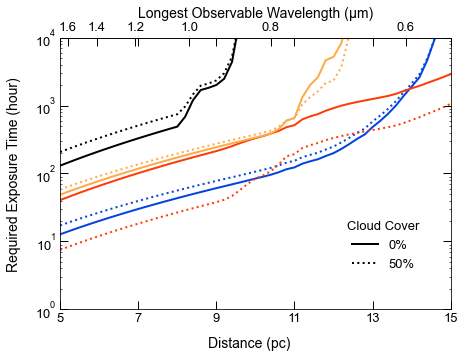

In [10]:
###################################################################################
# PLOTTING DT VS DISTANCES WITH WAVELENGTH
###################################################################################

data = ascii.read("DetectionTimes_with_distances_def.txt", data_start=0,  delimiter='\s')

for i in data['col1']:
    if 'Arthro_clearSky' in i:
        distance = data[0:51]['col3']
        Arthro_0 = data[0:51]['col4']
    #elif 'Arthro_mixed25' in i:
        #Arthro_25 = data[52:103]['col4']
    elif 'Arthro_mixed50' in i:
        Arthro_50 = data[104:155]['col4']
    #elif 'Arthro_mixed75' in i:
        #Arthro_75 = data[156:207]['col4']
    elif 'Ecto_clearSky' in i:
        Ecto_0 = data[208:259]['col4']
    #elif 'Ectoth_mixed25' in i:
        #Ecto_25 = data[260:311]['col4']
    elif 'Ectoth_mixed50' in i:
        Ecto_50 = data[312:363]['col4']
    #elif 'Ectoth_mixed75' in i:
        #Ecto_75 = data[364:415]['col4']  
    elif 'black_clearSky' in i:
        Black_0 = data[416:467]['col4']
    #elif 'blackmat_mixed25' in i:
        #Black_25 = data[468:519]['col4']
    elif 'blackmat_mixed50' in i:
        Black_50 = data[520:571]['col4']
    #elif 'blackmat_mixed75' in i:
        #Black_75 = data[572:623]['col4']
    elif 'orangemat_clearSky' in i:
        Orange_0 = data[624:675]['col4']
    #elif 'orangemat_mixed25' in i:
        #Orange_25 = data[676:727]['col4']
    elif 'orangemat_mixed50' in i:
        Orange_50 = data[728:779]['col4']
    #elif 'orangemat_mixed75' in i:
        #Orange_75 = data[780:831]['col4']
    else:
        pass

    
# For calculating an x-axis of wavelength:

# lambda = D/3.5 x sep          where D is the telescope diameter and sep is the angular separation. With
# sep = a/d ,                   where a is orbital distance and d is distance to the system, and taking a = 1 au, then
# sep (arcsec) = (1 au) / (d pc) 
# sep (radians) = (1 au) / (d pc) x 1/206265

# Inserting this into the equation above,
# lambda (micrometers) = (D meters)/3.5 x 1e6 x (1 au)/(d pc) x 1/206265
#With D = 6 meters, you get
# lambda (micrometers) = 8.31 / (d pc)

lamb = []
ds = np.arange(5, 15.2, 0.2)
for d in ds:
    lam = 8.31 / d
    lamb.append(lam)
    
    #print(len(lamb))
    #print(len(distance))

# Plot Dt vs Distance 
plt.rcParams.update({
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in'
})


font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
fig.set_facecolor('white')
fig.supxlabel('Distance (pc)', fontsize = 14, **font)
fig.supylabel('Required Exposure Time (hour)', fontsize = 14, **font)


ax.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 2.0, ls = 'solid')
#ax.plot(distance, Arthro_25, c = 'xkcd:blue', lw = 2.0, ls = 'dashed')
ax.plot(distance, Arthro_50, c = 'xkcd:blue', lw = 2.0, ls = 'dotted')
#ax.plot(distance, Arthro_75, c = 'xkcd:blue', lw = 2.0, ls = 'dashdot')
ax.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 2.0, ls = 'solid')
#ax.plot(distance, Ecto_25, c = 'xkcd:red orange', lw = 2.0, ls = 'dashed')
ax.plot(distance, Ecto_50, c = 'xkcd:red orange', lw = 2.0, ls = 'dotted')
#ax.plot(distance, Ecto_75, c = 'xkcd:red orange', lw = 2.0, ls = 'dashdot')   
ax.plot(distance, Black_0, c = 'xkcd:black', lw = 2.0, ls = 'solid', label = '0%')
#ax.plot(distance, Black_25, c = 'xkcd:black', lw = 2.0, ls = 'dashed', label = '25%')
ax.plot(distance, Black_50, c = 'xkcd:black', lw = 2.0, ls = 'dotted', label = '50%')
#ax.plot(distance, Black_75, c = 'xkcd:black', lw = 2.0, ls = 'dashdot', label = '75%')
ax.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 2.0, ls = 'solid')
#ax.plot(distance, Orange_25, c = 'xkcd:light orange', lw = 2.0, ls = 'dashed')
ax.plot(distance, Orange_50, c = 'xkcd:light orange', lw = 2.0, ls = 'dotted')
#ax.plot(distance, Orange_75, c = 'xkcd:light orange', lw = 2.0, ls = 'dashed')


def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 14, **font)
secax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=13)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 13)
ax.set_yscale("log")
ax.set_xlim(5, 15)
ax.set_ylim(bottom = 1, top = 10e3)
l = ax.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1) , frameon=False)
l.set_title(title = 'Cloud Cover', prop = legparams)


(1, 10000.0)

/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_2318/3086746850.py:76: RuntimeWarning: divide by zero encountered in true_divide
  return 8.31 / ds


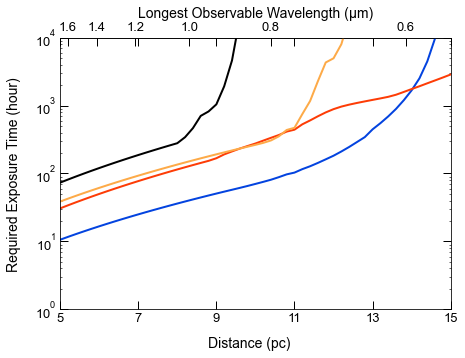

In [12]:
##################################
#### For low water vapor file ####
##################################

low_water_data = ascii.read('Low_water_DetectionTimes_distances_IWA_3.5.txt', data_start = 0, delimiter='\s')
#print(low_water_data[52:103]['col4'])
distance_lowwater = low_water_data[0:51]['col3']
Arthro_lowwater = low_water_data[0:51]['col4']
Ecto_lowwater = low_water_data[52:103]['col4'] 
Black_lowwater = low_water_data[104:155]['col4']
Orange_lowwater = low_water_data[156:207]['col4']

# for i in low_water_data['col1']:
#     if 'Arthro_clearSky' in i:
#         distance = low_water_data[0:51]['col3']
#         Arthro_lowwater = low_water_data[0:51]['col4']
#     elif 'Ecto_clearSky' in i:
#         Ecto_lowwater = low_water_data[52:103]['col4'] 
#     elif 'black_clearSky' in i:
#         Black_lowwater = low_water_data[104:155]['col4']
#     elif 'orangemat_clearSky' in i:
#         Orange_lowwater = low_water_data[156:207]['col4']
#     else:
#         pass
    
    
# For calculating an x-axis of wavelength:

# lambda = D/3.5 x sep          where D is the telescope diameter and sep is the angular separation. With
# sep = a/d ,                   where a is orbital distance and d is distance to the system, and taking a = 1 au, then
# sep (arcsec) = (1 au) / (d pc) 
# sep (radians) = (1 au) / (d pc) x 1/206265

# Inserting this into the equation above,
# lambda (micrometers) = (D meters)/3.5 x 1e6 x (1 au)/(d pc) x 1/206265
#With D = 6 meters, you get
# lambda (micrometers) = 8.31 / (d pc)

lamb = []
ds = np.arange(5, 15.2, 0.2)
for d in ds:
    lam = 8.31 / d
    lamb.append(lam)
    
    #print(len(lamb))
    #print(len(distance))

# Plot Dt vs Distance 
plt.rcParams.update({
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in'
})


font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(7, 5)
fig.set_facecolor('white')
fig.supxlabel('Distance (pc)', fontsize = 14, **font)
fig.supylabel('Required Exposure Time (hour)', fontsize = 14, **font)


ax.plot(distance_lowwater, Arthro_lowwater, c = 'xkcd:blue', lw = 2.0, ls = 'solid')
ax.plot(distance_lowwater, Ecto_lowwater, c = 'xkcd:red orange', lw = 2.0, ls = 'solid')
ax.plot(distance_lowwater, Black_lowwater, c = 'xkcd:black', lw = 2.0, ls = 'solid', label = '0%')
ax.plot(distance_lowwater, Orange_lowwater, c = 'xkcd:light orange', lw = 2.0, ls = 'solid')


def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 14, **font)
secax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=13)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 13)
ax.set_yscale("log")
ax.set_xlim(5, 15)
ax.set_ylim(bottom = 1, top = 10e3)
#ax.legend(fontsize = 13, title = 'Cloud Cover', prop = legparams);

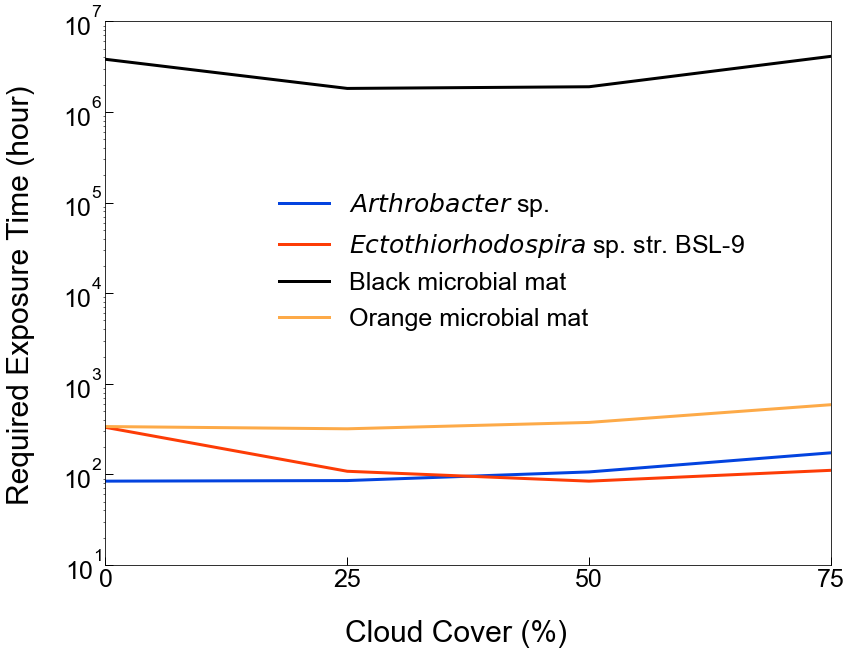

In [6]:
###################################################################################
# DT VS CLOUD COVER PLOT AT 10 PC
###################################################################################

data = ascii.read("DetectionTimes_10pc.txt", data_start=0,  delimiter='\s')


cloudcover = [0,25,50,75]

Arthro_0 = data[0]['col3']
Arthro_25 = data[1]['col3']
Arthro_50 = data[2]['col3']
Arthro_75 = data[3]['col3']

Arthro = [Arthro_0, Arthro_25, Arthro_50, Arthro_75]

Ecto_0 = data[4]['col3']
Ecto_25 = data[5]['col3']
Ecto_50 = data[6]['col3']
Ecto_75 = data[7]['col3']  

Ecto = [Ecto_0, Ecto_25, Ecto_50, Ecto_75]

Black_0 = data[8]['col3']
Black_25 = data[9]['col3']
Black_50 = data[10]['col3']
Black_75 = data[11]['col3']

Black = [Black_0, Black_25, Black_50, Black_75]

Orange_0 = data[12]['col3']
Orange_25 = data[13]['col3']
Orange_50 = data[14]['col3']
Orange_75 = data[15]['col3']

Orange = [Orange_0, Orange_25, Orange_50, Orange_75]


# Plot Dt vs Cloud Cover

font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
fig.set_facecolor('white')
fig.supxlabel('Cloud Cover (%)', fontsize = 30, **font)
fig.supylabel('Required Exposure Time (hour)', fontsize = 30, **font)

ax.plot(cloudcover, Arthro, c = 'xkcd:blue', lw = 3.0, ls = 'solid', label = '$\it{Arthrobacter}$ sp.')
ax.plot(cloudcover, Ecto, c = 'xkcd:red orange', lw = 3.0, ls = 'solid', label = '$\it{Ectothiorhodospira}$ sp. str. BSL-9')  
ax.plot(cloudcover, Black, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Black microbial mat')
ax.plot(cloudcover, Orange, c = 'xkcd:light orange', lw = 3.0, ls = 'solid', label = 'Orange microbial mat')
ax.set_yscale("log")
plt.xticks(np.arange(0, 100, step=25))  # Set label locations.
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=25)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
ax.set_xlim(0, 75)
ax.set_ylim(10e0, 10e6)
ax.legend(fontsize = 25, ncol=1, prop = legparams, frameon=False, loc='center', bbox_to_anchor=(0.56, 0.56))

#plt.savefig('Dt' + '_allmicrobes_20220503.tiff', dpi=400, transparent=True)


/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_78377/508909995.py:62: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1000)


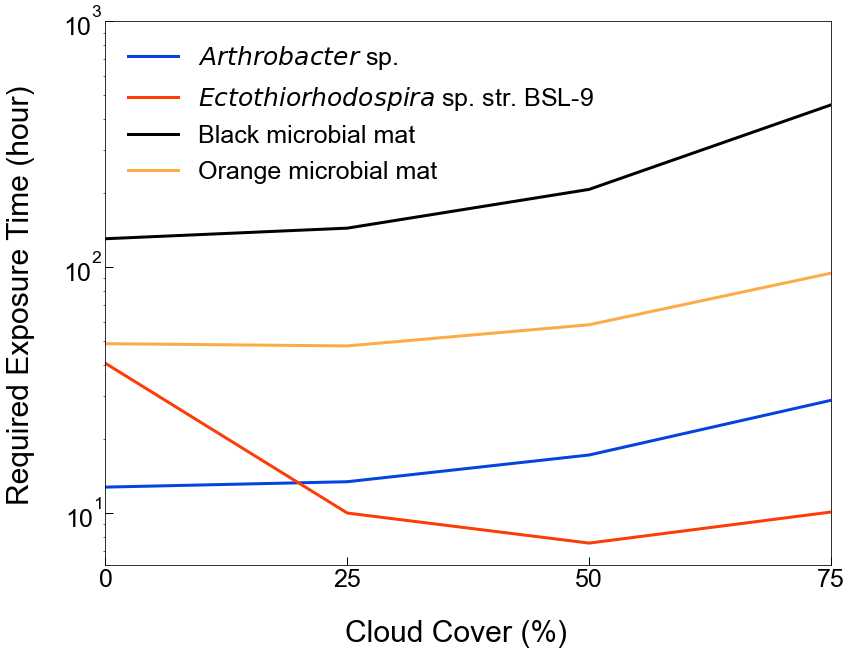

In [17]:
###################################################################################
# DT VS CLOUD COVER PLOT AT 5 PC
###################################################################################

data = ascii.read("/Users/schuylerraeschroerborges/Desktop/Second_Project/DetectionTimes_5pc.txt", data_start=0,  delimiter='\s')


cloudcover = [0,25,50,75]

Arthro_0 = data[0]['col3']
Arthro_25 = data[1]['col3']
Arthro_50 = data[2]['col3']
Arthro_75 = data[3]['col3']

Arthro = [Arthro_0, Arthro_25, Arthro_50, Arthro_75]

Ecto_0 = data[4]['col3']
Ecto_25 = data[5]['col3']
Ecto_50 = data[6]['col3']
Ecto_75 = data[7]['col3']  

Ecto = [Ecto_0, Ecto_25, Ecto_50, Ecto_75]

Black_0 = data[8]['col3']
Black_25 = data[9]['col3']
Black_50 = data[10]['col3']
Black_75 = data[11]['col3']

Black = [Black_0, Black_25, Black_50, Black_75]

Orange_0 = data[12]['col3']
Orange_25 = data[13]['col3']
Orange_50 = data[14]['col3']
Orange_75 = data[15]['col3']

Orange = [Orange_0, Orange_25, Orange_50, Orange_75]


# Plot Dt vs Cloud Cover

font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
fig.set_facecolor('white')
fig.supxlabel('Cloud Cover (%)', fontsize = 30, **font)
fig.supylabel('Required Exposure Time (hour)', fontsize = 30, **font)

ax.plot(cloudcover, Arthro, c = 'xkcd:blue', lw = 3.0, ls = 'solid', label = '$\it{Arthrobacter}$ sp.')
ax.plot(cloudcover, Ecto, c = 'xkcd:red orange', lw = 3.0, ls = 'solid', label = '$\it{Ectothiorhodospira}$ sp. str. BSL-9')  
ax.plot(cloudcover, Black, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Black microbial mat')
ax.plot(cloudcover, Orange, c = 'xkcd:light orange', lw = 3.0, ls = 'solid', label = 'Orange microbial mat')
ax.set_yscale("log")
plt.xticks(np.arange(0, 100, step=25))  # Set label locations.
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=25)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
ax.set_xlim(0, 75)
ax.set_ylim(0, 1000)
ax.legend(fontsize = 25, ncol=1, prop = legparams, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.0))

#plt.savefig('Dt' + '_allmicrobes_20220503.tiff', dpi=400, transparent=True)

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


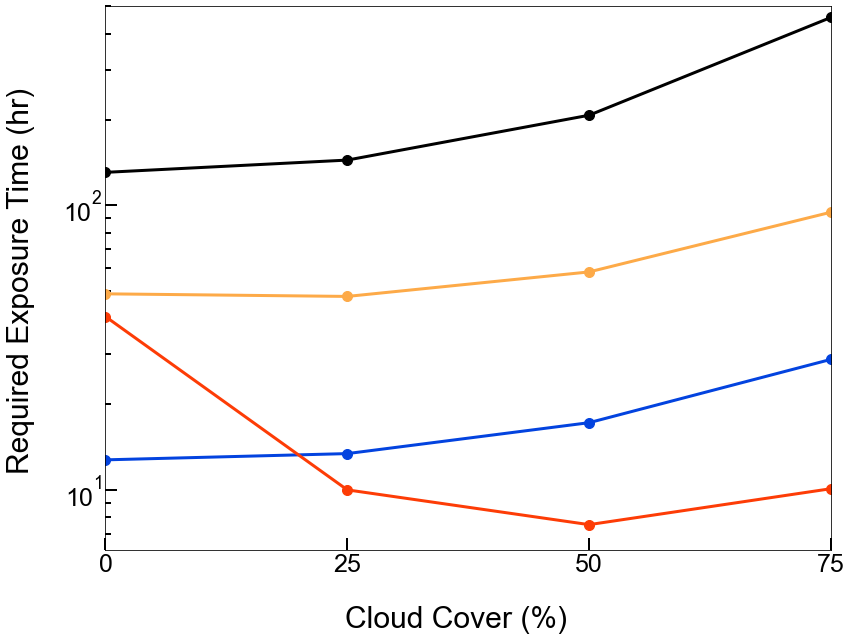

In [18]:
###################################################################################
# DT VS CLOUD COVER PLOT AT 5 PC
###################################################################################

data = ascii.read("/Users/schuylerraeschroerborges/Desktop/Second_Project/DetectionTimes_5pc.txt", data_start=0,  delimiter='\s')


cloudcover = [0,25,50,75]

Arthro_0 = data[0]['col3']
Arthro_25 = data[1]['col3']
Arthro_50 = data[2]['col3']
Arthro_75 = data[3]['col3']

Arthro = [Arthro_0, Arthro_25, Arthro_50, Arthro_75]

Ecto_0 = data[4]['col3']
Ecto_25 = data[5]['col3']
Ecto_50 = data[6]['col3']
Ecto_75 = data[7]['col3']  

Ecto = [Ecto_0, Ecto_25, Ecto_50, Ecto_75]

Black_0 = data[8]['col3']
Black_25 = data[9]['col3']
Black_50 = data[10]['col3']
Black_75 = data[11]['col3']

Black = [Black_0, Black_25, Black_50, Black_75]

Orange_0 = data[12]['col3']
Orange_25 = data[13]['col3']
Orange_50 = data[14]['col3']
Orange_75 = data[15]['col3']

Orange = [Orange_0, Orange_25, Orange_50, Orange_75]


# Plot Dt vs Cloud Cover

font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
fig.set_facecolor('white')
fig.supxlabel('Cloud Cover (%)', fontsize = 30, **font)
fig.supylabel('Required Exposure Time (hr)', fontsize = 30, **font)

ax.plot(cloudcover, Arthro, c = 'xkcd:blue', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = '$\it{Arthrobacter}$ sp.')
ax.plot(cloudcover, Ecto, c = 'xkcd:red orange', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = '$\it{Ectothiorhodospira}$ sp. str. BSL-9')  
ax.plot(cloudcover, Black, c = 'xkcd:black', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = 'Black microbial mat')
ax.plot(cloudcover, Orange, c = 'xkcd:light orange', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = 'Orange microbial mat')
ax.set_yscale("log")
plt.xticks(np.arange(0, 100, step=25))  # Set label locations.
ax.tick_params(axis='both', direction='in',length=12, width=2, labelsize=25)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
ax.tick_params(axis='y', which='minor', direction='in',length=6, width=2)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
ax.set_xlim(0, 75)
ax.set_ylim(0, 500)
#ax.legend(fontsize = 25, ncol=1, prop = legparams, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.0))

plt.savefig('/Users/schuylerraeschroerborges/Downloads/Surface_biosignature_fig9.eps', format='eps')

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


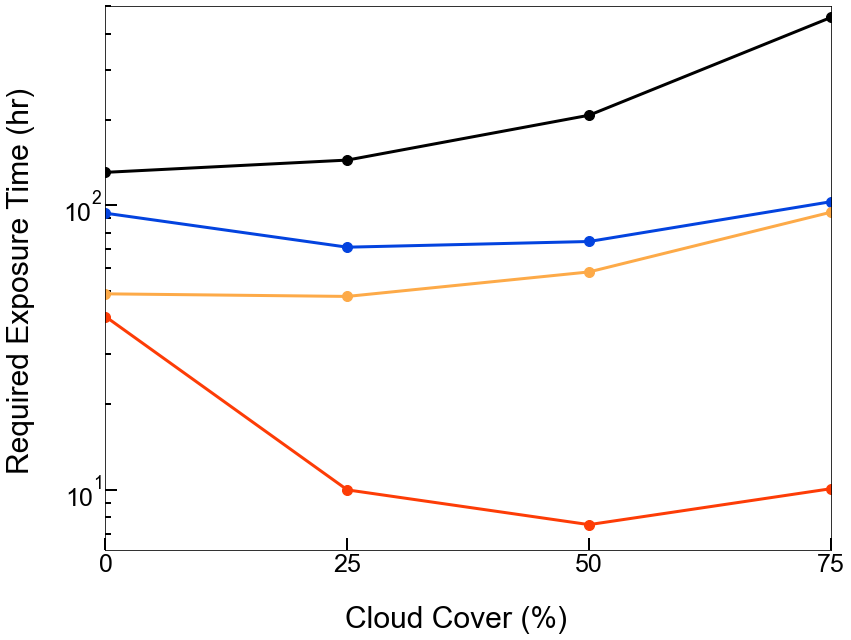

In [18]:
###################################################################################
# DT VS CLOUD COVER PLOT AT 5 PC
###################################################################################

data = ascii.read("/Users/schuylerraeschroerborges/Desktop/Second_Project/DetectionTimes_new_arthro_5pc.txt", data_start=0,  delimiter='\s')


cloudcover = [0,25,50,75]

Arthro_0 = data[0]['col3']
Arthro_25 = data[1]['col3']
Arthro_50 = data[2]['col3']
Arthro_75 = data[3]['col3']

Arthro = [Arthro_0, Arthro_25, Arthro_50, Arthro_75]

Ecto_0 = data[4]['col3']
Ecto_25 = data[5]['col3']
Ecto_50 = data[6]['col3']
Ecto_75 = data[7]['col3']  

Ecto = [Ecto_0, Ecto_25, Ecto_50, Ecto_75]

Black_0 = data[8]['col3']
Black_25 = data[9]['col3']
Black_50 = data[10]['col3']
Black_75 = data[11]['col3']

Black = [Black_0, Black_25, Black_50, Black_75]

Orange_0 = data[12]['col3']
Orange_25 = data[13]['col3']
Orange_50 = data[14]['col3']
Orange_75 = data[15]['col3']

Orange = [Orange_0, Orange_25, Orange_50, Orange_75]


# Plot Dt vs Cloud Cover

font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
fig.set_facecolor('white')
fig.supxlabel('Cloud Cover (%)', fontsize = 30, **font)
fig.supylabel('Required Exposure Time (hr)', fontsize = 30, **font)

ax.plot(cloudcover, Arthro, c = 'xkcd:blue', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = '$\it{Arthrobacter}$ sp.')
ax.plot(cloudcover, Ecto, c = 'xkcd:red orange', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = '$\it{Ectothiorhodospira}$ sp. str. BSL-9')  
ax.plot(cloudcover, Black, c = 'xkcd:black', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = 'Black microbial mat')
ax.plot(cloudcover, Orange, c = 'xkcd:light orange', lw = 3.0, marker='o', markersize=10, ls = 'solid', label = 'Orange microbial mat')
ax.set_yscale("log")
plt.xticks(np.arange(0, 100, step=25))  # Set label locations.
ax.tick_params(axis='both', direction='in',length=12, width=2, labelsize=25)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
ax.tick_params(axis='y', which='minor', direction='in',length=6, width=2)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
ax.set_xlim(0, 75)
ax.set_ylim(0, 500)
#ax.legend(fontsize = 25, ncol=1, prop = legparams, frameon=False, loc='upper left', bbox_to_anchor=(0, 1.0))

plt.savefig('/Users/schuylerraeschroerborges/Downloads/Figure9.tif', format='tif')

In [450]:
###################################################################################
# FAUX OBSERVATION PLOT WITH ERROR BARS
###################################################################################

outfile = "SNR_all.txt"
f = open(outfile, 'w')
 
    
def noise_model_errors(lamhr, AX_refhr, AY_refhr, AX_solhr, AY_solhr, x_file, y_file):
    # Planet params
    planet = cg.Planet()
    planet.alpha = 90.     # phase angle at quadrature
    planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
    planet.Rp    = 1.0     # Earth radii
    planet.a     = 1.0     # semi-major axis (AU)

    # Stellar params
    star = cg.Star()
    star.Teff  = 5780.   # Sun-like Teff (K)
    star.Rs    = 1.      # star radius in solar radii
    

    # Planetary system params
    planet.distance    = 5.    # distance to system (pc)
    planet.Nez  = 1.      # number of exo-zodis

    telescope = cg.Telescope()

    # Set paramaters for luvex
    telescope.diameter = 6.0
    telescope.contrast = 1e-10
    telescope.A_collect = 36.
    telescope.diam_inscribed = 6.0
    telescope.Tsys = 270.
    telescope.OWA = 24.
    telescope.IWA = 3.5
    telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
    telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
    telescope.emis = 0.7
    telescope.Dtmax = 1.0e3/3600
    telescope.X = .61

    # Visible channel parameters:
    telescope.resolution = 140.
    telescope.throughput = 0.15
    telescope.darkcurrent = 3e-5
    telescope.readnoise = 0.0
    telescope.lammin = 0.4
    telescope.lammax = 1.030
    
    
    # Running the different coronagraph object to run count rates for AX and AY
    noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
    noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 10.0,
                            wantsnr = 5.0)
    
    # running count rates to calculate Dt
    noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
    noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)

###################################################################################
# CALCULATING SNR AND ERROR BARS WITHOUT CORONAGRAPH
###################################################################################

    for i in range(len(noise_AX.A)):
    # Calculating the wavelength-dependent SNR to derive error bars for faux observed spectrum
        signalnratio_AX = noise_AX.wantsnr * (500/noise_AX.DtSNR[i])**(1/2)
        signalnratio_AY = noise_AY.wantsnr * (500/noise_AY.DtSNR[i])**(1/2)
        
        x_error = noise_AX.Aobs[i]/signalnratio_AX
        y_error = noise_AY.Aobs[i]/signalnratio_AY
    
        string = str(ax_file) + "  " +  "AX" + "  " + "      %g" % (x_error) + \
        "  " + str(ay_file) + "  " + "AY" + "  " + "      %g" % (y_error)
        f.write(string + "\n")
    

    return f.write(string + "\n")



# FOR CALCULATING ALL MICROBES AND CLOUD MIXTURES (16)
# for i in np.arange(0, len(file_list), 2):
#     ax_file = file_list[i]
#     ay_file = file_list[i+1]
#     AX_data = newcols(ax_file)
#     AY_data = newcols(ay_file)

#     lam = np.array(AX_data[0])    # Lambda
#     AX_sol = np.array(AX_data[1])    # Solar flux AX 
#     AX_rad = np.array(AX_data[2])    # radiance AX
#     AX_ref = np.array(AX_data[3])    # Reflectance of AX

#     AY_sol = np.array(AY_data[1])    # Solar flux AY
#     AY_rad = np.array(AY_data[2])    # radiance AY
#     AY_ref = np.array(AY_data[3])    # Reflectance of AY 
    
#     noise_model_errors(lam, AX_ref, AY_ref, AX_sol, AY_sol, ax_file, ay_file)
    
# f.close()
    
    

# FOR CALCULATING THE SNR AND ERROR FOR THE EASIEST TO DETECT MICROBE, ARTHROBACTER SP.

outfile = "Error_Arthro.txt"
f = open(outfile, 'w')


files = (['Arthro_clearSky_mon_toa.rad', 'Arthro_clearSky_scrubbed_updated_mon_toa.rad'])
arthrox_file = files[0]
arthroy_file = files[1]
ArthroX_data = newcols(ax_file)
ArthroY_data = newcols(ay_file)

lam = np.array(ArthroX_data[0])    # Lambda
ArthroX_sol = np.array(ArthroX_data[1])    # Solar flux AX 
ArthroX_rad = np.array(ArthroX_data[2])    # radiance AX
ArthroX_ref = np.array(ArthroX_data[3])    # Reflectance of AX

ArthroY_sol = np.array(ArthroY_data[1])    # Solar flux AY
ArthroY_rad = np.array(ArthroY_data[2])    # radiance AY
ArthroY_ref = np.array(ArthroY_data[3])    # Reflectance of AY

noise_model_errors(lam, ArthroX_ref, ArthroY_ref, ArthroX_sol, ArthroY_sol, arthrox_file, arthroy_file)

f.close()



134


NameError: name 'noise_AX' is not defined

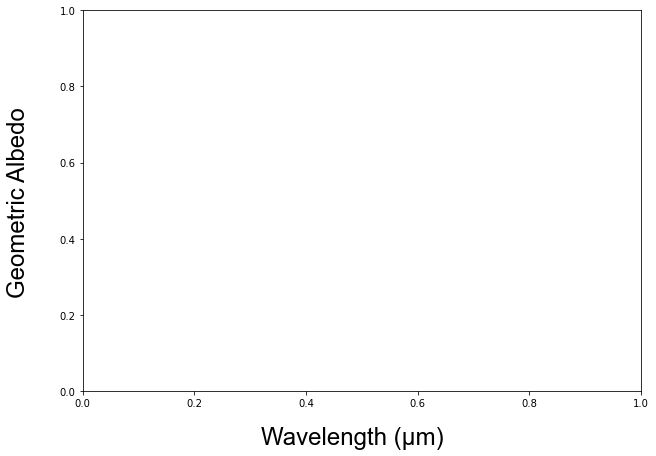

In [3]:
error = ascii.read("Error_Arthro.txt", data_start=0,  delimiter='\s')
print(len(error['col3']))

font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
fig.set_facecolor('white')
fig.supxlabel('Wavelength (' + u'\u03bc' + 'm)', fontsize = 24, **font)
fig.supylabel('Geometric Albedo', fontsize = 24, **font)

ax.plot(noise_AX.lam, noise_AX.A, c = 'xkcd:orange', lw = 2.0, ls = '-')
ax.plot(noise_AY.lam, noise_AY.A, lw = 2.0, ls = 'dashed')
ax.errorbar(noise_AX.lam, noise_AX.Aobs, yerr=error['col3'], fmt = ".", c = 'xkcd:blue', ms = 3, lw = 1.0, label = 'Arthrobacter sp.')
ax.errorbar(noise_AY.lam, noise_AY.Aobs, yerr=error['col6'], fmt = ".", c = "k", ms = 3, lw = 1.0, label = "Arthrobacter sp. without pigments")
ax.set_xlim(0.4,1.030)
plt.xticks(np.arange(0.4, 1.03, step=0.2))  # Set x tick locations.
plt.yticks(np.arange(0.1, 0.25, step=0.1))  # Set y tick locations.
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 20)
ax.set_ylim(bottom = 0.0, top = 0.25)
ax.legend(fontsize = 20, ncol=1, prop = legparams)
    
        
plt.show()

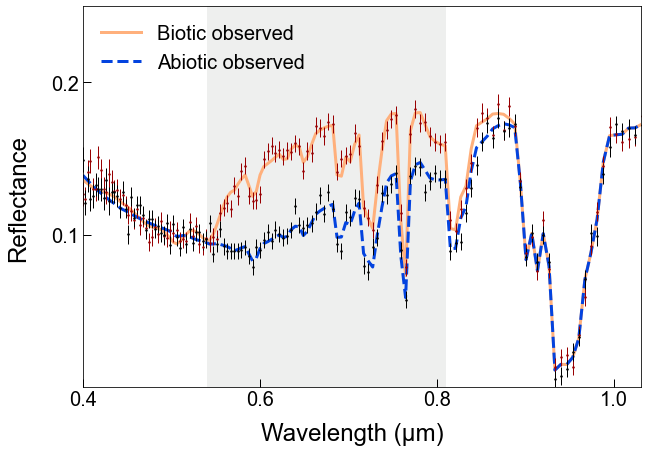

<Figure size 432x288 with 0 Axes>

In [8]:
###################################################################################
# CALCULATING SNR AND ERROR BARS OF ARTHROBACTER SP. CLEAR SKIES WITH CORONAGRAPH
###################################################################################
outfile = "SNR_Arthro.txt"
f = open(outfile, 'w')


files = (['Arthro_clearSky_mon_toa.rad', 'Arthro_clearSky_scrubbed_updated_mon_toa.rad'])
for i in np.arange(0, len(files), 2):
    ax_file = files[i]
    ay_file = files[i+1]
    AX_data = newcols(ax_file)
    AY_data = newcols(ay_file)

    lamhr = np.array(AX_data[0])    # Lambda
    AX_solhr = np.array(AX_data[1])    # Solar flux AX 
    AX_radhr = np.array(AX_data[2])    # radiance AX
    AX_refhr = np.array(AX_data[3])    # Reflectance of AX

    AY_solhr = np.array(AY_data[1])    # Solar flux AY
    AY_radhr = np.array(AY_data[2])    # radiance AY
    AY_refhr = np.array(AY_data[3])    # Reflectance of AY
                        
                        
###################################################################################
# RETRIEVING CP0 FOR ALBEDO OF ONE
###################################################################################

    planet = cg.Planet()
    
    # Planet params
    planet.alpha = 90.     # phase angle at quadrature
    planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
    planet.Rp    = 1.0     # Earth radii
    planet.a     = 1.0     # semi-major axis (AU)

    # Stellar params
    star = cg.Star()
    star.Teff  = 5780.   # Sun-like Teff (K)
    star.Rs    = 1.      # star radius in solar radii
    

    # Planetary system params
    planet.distance = 7.5    # distance to system (pc)
    planet.Nez  = 1.      # number of exo-zodis

    telescope = cg.Telescope()

    # Set paramaters for luvex
    telescope.diameter = 6.0
    telescope.contrast = 1e-10
    telescope.A_collect = 36.
    telescope.diam_inscribed = 6.0
    telescope.Tsys = 270.
    telescope.OWA = 24.
    telescope.IWA = 3.5
    telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
    telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
    telescope.emis = 0.7
    telescope.Dtmax = 1.0e3/3600
    telescope.X = .61

    # Visible channel parameters:
    telescope.resolution = 140.
    telescope.throughput = 0.15
    telescope.darkcurrent = 3e-5
    telescope.readnoise = 0.0
    telescope.lammin = 0.4
    telescope.lammax = 1.030
    
    
    # Running the different coronagraph object to run count rates for AX and AY
    noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    # running count rates to calculate Dt
    noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
    noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)
    
###################################################################################
# PLOTTING OBSERVATIONS AND ERROR BARS
###################################################################################

    font = {'fontname':'Arial'}

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    fig.set_facecolor('white')
    fig.supxlabel('Wavelength (' + u'\u03bc' + 'm)', fontsize = 24, **font)
    fig.supylabel('Reflectance', fontsize = 24, **font)

    ax.plot(noise_AX.lam, noise_AX.A, c = 'xkcd:peach', lw = 3.0, ls = '-', label = 'Biotic observed' )
    ax.plot(noise_AY.lam, noise_AY.A, c = 'xkcd:blue', lw = 3.0, ls = 'dashed', label = 'Abiotic observed')
    ax.errorbar(noise_AX.lam, noise_AX.Aobs, yerr=noise_AX.Asig, fmt = ".", c = 'xkcd:blood red', ms = 3, lw = 1.0, label = '_Biotic error')
    ax.errorbar(noise_AY.lam, noise_AY.Aobs, yerr=noise_AY.Asig, fmt = ".", c = "k", ms = 3, lw = 1.0, label = "_Abiotic error")
    ax.set_xlim(0.4,1.030)
    plt.xticks(np.arange(0.4, 1.03, step=0.2))  # Set x tick locations.
    plt.yticks(np.arange(0.1, 0.25, step=0.1))  # Set y tick locations.
    ax.tick_params(direction='in',length=8, width=1, labelsize=20)
    ax.axvspan(xmin=0.54, xmax=0.81, facecolor='xkcd:grey', alpha=0.15)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    legparams = font_manager.FontProperties(family = 'Arial', size = 20)
    ax.set_ylim(bottom = 0.0, top = 0.25)
    ax.legend(fontsize = 20, ncol=1, prop = legparams, frameon=False, loc='upper left')
    
        
    plt.show()
    #plt.savefig('/Users/schuylerraeschroerborges/Downloads/Surface_biosignature_fig6.eps', format='eps')

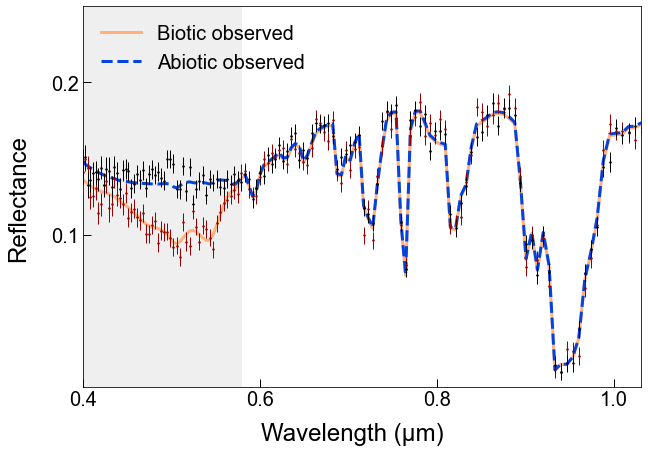

In [2]:
###################################################################################
# CALCULATING SNR AND ERROR BARS OF ARTHROBACTER SP. CLEAR SKIES WITH CORONAGRAPH
###################################################################################
outfile = "SNR_Arthro.txt"
f = open(outfile, 'w')


files = (['Arthro_clearSky_mon_toa.rad', 'Arthro_clearSky_scrub_v3_um_toa.rad'])
for i in np.arange(0, len(files), 2):
    ax_file = files[i]
    ay_file = files[i+1]
    AX_data = newcols(ax_file)
    AY_data = newcols(ay_file)

    lamhr = np.array(AX_data[0])    # Lambda
    AX_solhr = np.array(AX_data[1])    # Solar flux AX 
    AX_radhr = np.array(AX_data[2])    # radiance AX
    AX_refhr = np.array(AX_data[3])    # Reflectance of AX

    AY_solhr = np.array(AY_data[1])    # Solar flux AY
    AY_radhr = np.array(AY_data[2])    # radiance AY
    AY_refhr = np.array(AY_data[3])    # Reflectance of AY
                        
                        
###################################################################################
# RETRIEVING CP0 FOR ALBEDO OF ONE
###################################################################################

    planet = cg.Planet()
    
    # Planet params
    planet.alpha = 90.     # phase angle at quadrature
    planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
    planet.Rp    = 1.0     # Earth radii
    planet.a     = 1.0     # semi-major axis (AU)

    # Stellar params
    star = cg.Star()
    star.Teff  = 5780.   # Sun-like Teff (K)
    star.Rs    = 1.      # star radius in solar radii
    

    # Planetary system params
    planet.distance = 7.5    # distance to system (pc)
    planet.Nez  = 1.      # number of exo-zodis

    telescope = cg.Telescope()

    # Set paramaters for luvex
    telescope.diameter = 6.0
    telescope.contrast = 1e-10
    telescope.A_collect = 36.
    telescope.diam_inscribed = 6.0
    telescope.Tsys = 270.
    telescope.OWA = 24.
    telescope.IWA = 3.5
    telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
    telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
    telescope.emis = 0.7
    telescope.Dtmax = 1.0e3/3600
    telescope.X = .61

    # Visible channel parameters:
    telescope.resolution = 140.
    telescope.throughput = 0.15
    telescope.darkcurrent = 3e-5
    telescope.readnoise = 0.0
    telescope.lammin = 0.4
    telescope.lammax = 1.030
    
    
    # Running the different coronagraph object to run count rates for AX and AY
    noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    # running count rates to calculate Dt
    noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
    noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)
    
###################################################################################
# PLOTTING OBSERVATIONS AND ERROR BARS
###################################################################################

    font = {'fontname':'Arial'}

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    fig.set_facecolor('white')
    fig.supxlabel('Wavelength (' + u'\u03bc' + 'm)', fontsize = 24, **font)
    fig.supylabel('Reflectance', fontsize = 24, **font)

    ax.plot(noise_AX.lam, noise_AX.A, c = 'xkcd:peach', lw = 3.0, ls = '-', label = 'Biotic observed' )
    ax.plot(noise_AY.lam, noise_AY.A, c = 'xkcd:blue', lw = 3.0, ls = 'dashed', label = 'Abiotic observed')
    ax.errorbar(noise_AX.lam, noise_AX.Aobs, yerr=noise_AX.Asig, fmt = ".", c = 'xkcd:blood red', ms = 3, lw = 1.0, label = '_Biotic error')
    ax.errorbar(noise_AY.lam, noise_AY.Aobs, yerr=noise_AY.Asig, fmt = ".", c = "k", ms = 3, lw = 1.0, label = "_Abiotic error")
    ax.set_xlim(0.4,1.030)
    plt.xticks(np.arange(0.4, 1.03, step=0.2))  # Set x tick locations.
    plt.yticks(np.arange(0.1, 0.25, step=0.1))  # Set y tick locations.
    ax.tick_params(direction='in',length=8, width=1, labelsize=20)
    ax.axvspan(xmin=0.35, xmax=0.58, facecolor='xkcd:grey', alpha=0.15)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    legparams = font_manager.FontProperties(family = 'Arial', size = 20)
    ax.set_ylim(bottom = 0.0, top = 0.25)
    ax.legend(fontsize = 20, ncol=1, prop = legparams, frameon=False, loc='upper left')
    
        
    plt.show()
    #plt.savefig('/Users/schuylerraeschroerborges/Downloads/Surface_biosignature_fig6.eps', format='eps')

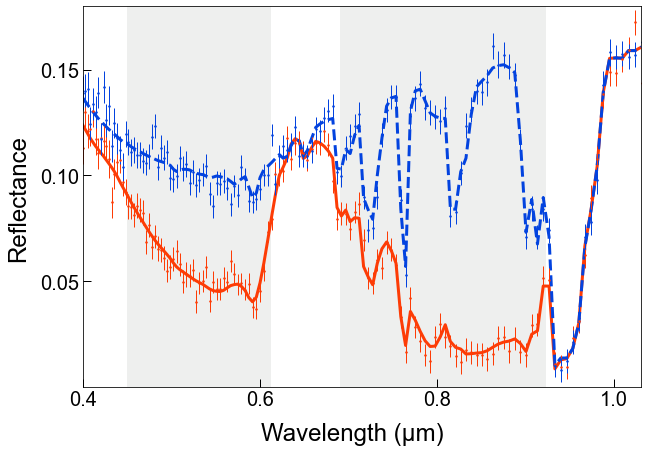

In [37]:
###################################################################################
# CALCULATING SNR AND ERROR BARS OF ECTOTHIORHODOSPIRA SP. STR. BSL-9 CLEAR SKIES WITH CORONAGRAPH
###################################################################################
outfile = "SNR_Ecto.txt"
f = open(outfile, 'w')


files = (['Ecto_clearSky_new_toa.rad', 'Ectoth_clearSky_scrubbed_mon_toa.rad'])
for i in np.arange(0, len(files), 2):
    ax_file = files[i]
    ay_file = files[i+1]
    AX_data = newcols(ax_file)
    AY_data = newcols(ay_file)

    lamhr = np.array(AX_data[0])    # Lambda
    AX_solhr = np.array(AX_data[1])    # Solar flux AX 
    AX_radhr = np.array(AX_data[2])    # radiance AX
    AX_refhr = np.array(AX_data[3])    # Reflectance of AX

    AY_solhr = np.array(AY_data[1])    # Solar flux AY
    AY_radhr = np.array(AY_data[2])    # radiance AY
    AY_refhr = np.array(AY_data[3])    # Reflectance of AY
                        
                        
###################################################################################
# RETRIEVING CP0 FOR ALBEDO OF ONE
###################################################################################

    planet = cg.Planet()
    
    # Planet params
    planet.alpha = 90.     # phase angle at quadrature
    planet.Phi   = cg.teleplanstar.lambertPhaseFunction(1)      # phase function at quadrature (already included in SMART run)
    planet.Rp    = 1.0     # Earth radii
    planet.a     = 1.0     # semi-major axis (AU)

    # Stellar params
    star = cg.Star()
    star.Teff  = 5780.   # Sun-like Teff (K)
    star.Rs    = 1.      # star radius in solar radii
    

    # Planetary system params
    planet.distance = 7.5    # distance to system (pc)
    planet.Nez  = 1.      # number of exo-zodis

    telescope = cg.Telescope()

    # Set paramaters for luvex
    telescope.diameter = 6.0
    telescope.contrast = 1e-10
    telescope.A_collect = 36.
    telescope.diam_inscribed = 6.0
    telescope.Tsys = 270.
    telescope.OWA = 24.
    telescope.IWA = 3.5
    telescope.qe = 0.9 * 0.75   # Detector QE * charge transfer term
    telescope.Rc = 2.0e-3       # Clock induced charge [counts/pixel/photon]
    telescope.emis = 0.7
    telescope.Dtmax = 1.0e3/3600
    telescope.X = .61

    # Visible channel parameters:
    telescope.resolution = 140.
    telescope.throughput = 0.15
    telescope.darkcurrent = 3e-5
    telescope.readnoise = 0.0
    telescope.lammin = 0.4
    telescope.lammax = 1.030
    
    
    # Running the different coronagraph object to run count rates for AX and AY
    noise_AX = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    noise_AY = cg.CoronagraphNoise(telescope = telescope,
                            planet = planet,
                            star = star,
                            texp = 100.0,
                            wantsnr = 5.0)
    
    # running count rates to calculate Dt
    noise_AX.run_count_rates(AX_refhr, lamhr, AX_solhr)
    
    noise_AY.run_count_rates(AY_refhr, lamhr, AY_solhr)
    
###################################################################################
# PLOTTING OBSERVATIONS AND ERROR BARS
###################################################################################

    font = {'fontname':'Arial'}

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)
    fig.set_facecolor('white')
    fig.supxlabel('Wavelength (' + u'\u03bc' + 'm)', fontsize = 24, **font)
    fig.supylabel('Reflectance', fontsize = 24, **font)

    ax.plot(noise_AX.lam, noise_AX.A, c = 'xkcd:red orange', lw = 3.0, ls = '-', label = 'Biotic observed' )
    ax.plot(noise_AY.lam, noise_AY.A, c = 'xkcd:blue', lw = 3.0, ls = 'dashed', label = 'Abiotic observed')
    ax.errorbar(noise_AX.lam, noise_AX.Aobs, yerr=noise_AX.Asig, fmt = ".", c = 'xkcd:red orange', ms = 3, lw = 1.0, label = '_Biotic error')
    ax.errorbar(noise_AY.lam, noise_AY.Aobs, yerr=noise_AY.Asig, fmt = ".", c = "xkcd:blue", ms = 3, lw = 1.0, label = "_Abiotic error")
    ax.set_xlim(0.4,1.030)
    plt.xticks(np.arange(0.4, 1.03, step=0.2))  # Set x tick locations.
    plt.yticks(np.arange(0.05, 0.2, step=0.05))  # Set y tick locations.
    ax.tick_params(direction='in',length=8, width=1, labelsize=20)
    ax.axvspan(xmin=0.45, xmax=0.612, facecolor='xkcd:grey', alpha=0.15)
    ax.axvspan(xmin=0.69, xmax=0.923, facecolor='xkcd:grey', alpha=0.15)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    legparams = font_manager.FontProperties(family = 'Arial', size = 20)
    ax.set_ylim(bottom = 0.0, top = 0.18)
    #ax.legend(fontsize = 20, ncol=1, prop = legparams, frameon=False, loc='upper left')
    
    plt.savefig('/Users/schuylerraeschroerborges/Downloads/Figure6.tif', format='tif')

/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_2318/2003304238.py:41: RuntimeWarning: divide by zero encountered in true_divide
  return 8.31 / ds


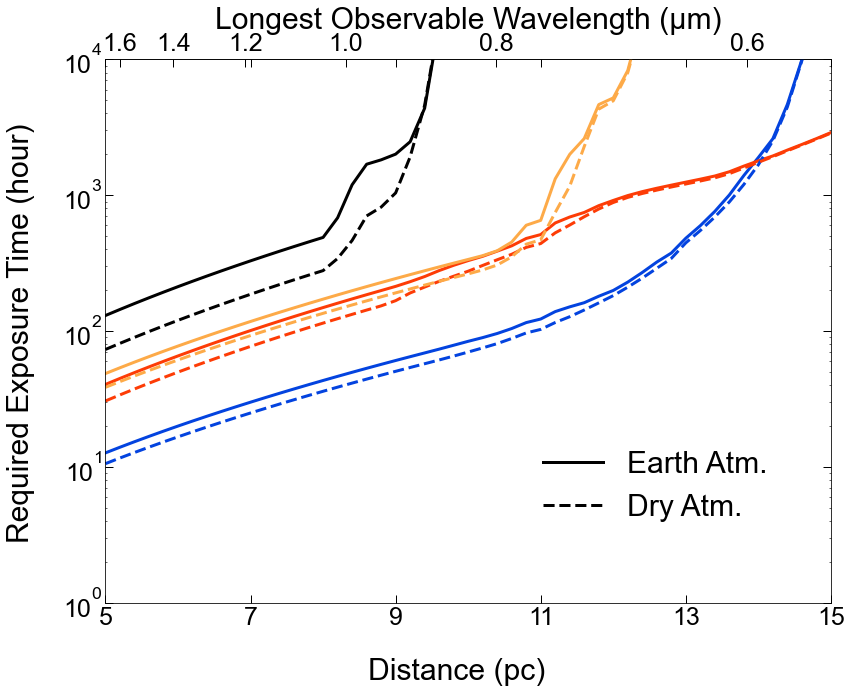

In [14]:
###################################################################################
# DT VS DISTANCES FOR EARTH'S WATER VAPOR AND LOW WATER VAPOR
###################################################################################


# Plot Dt vs Distance 
plt.rcParams.update({
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in'
})


font = {'fontname':'Arial'}

fig, ax = plt.subplots()
fig.set_size_inches(13, 10)
fig.set_facecolor('white')
fig.supxlabel('Distance (pc)', fontsize = 30, **font)
fig.supylabel('Required Exposure Time (hour)', fontsize = 30, **font)


ax.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')  
ax.plot(distance, Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Earth Atm.')
ax.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')


ax.plot(distance_lowwater, Arthro_lowwater, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax.plot(distance_lowwater, Ecto_lowwater, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax.plot(distance_lowwater, Black_lowwater, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = 'Dry Atm.')
ax.plot(distance_lowwater, Orange_lowwater, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')



def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 30, **font)
secax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=25)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=8, width=1, labelsize=25)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 30)
ax.set_yscale("log")
ax.set_xlim(5, 15)
ax.set_ylim(bottom = 1, top = 10e3)
ax.legend(fontsize = 30, prop = legparams, frameon=False, loc='lower right', bbox_to_anchor=(0.95, 0.1));



[]

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide


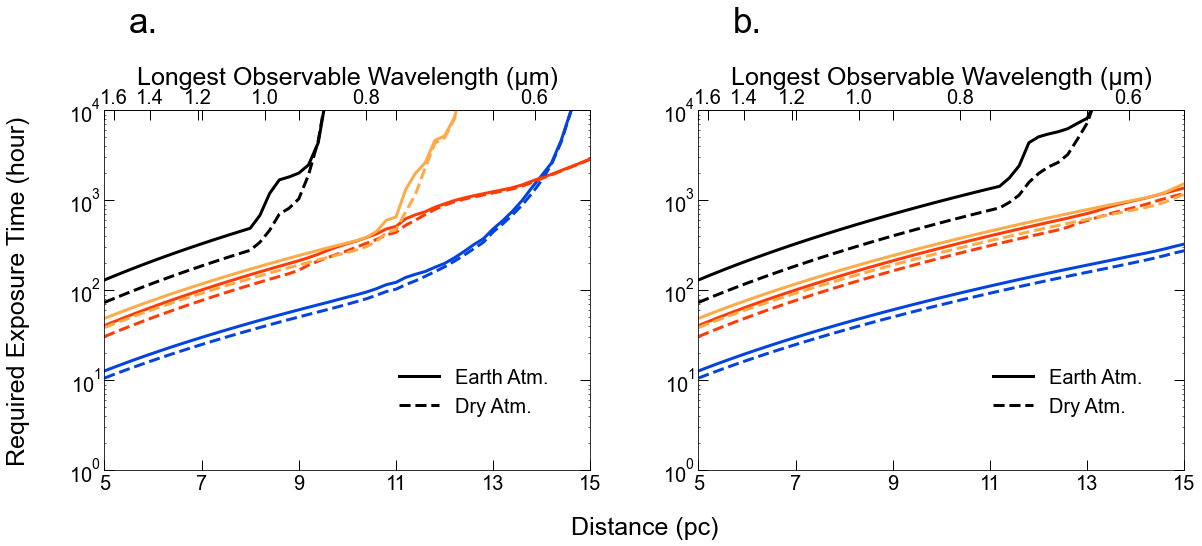

In [19]:
###################################################################################
# DT VS DISTANCES FOR EARTH'S WATER VAPOR AND LOW WATER VAPOR
###################################################################################

Earth_3 = ascii.read("DetectionTimes_with_distances_def.txt", data_start=0,  delimiter='\s')
Earth_2 = ascii.read('DetectionTimes_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

Dry_3 = ascii.read("Low_water_DetectionTimes_distances_IWA_3.5.txt", data_start=0,  delimiter='\s')
Dry_2 = ascii.read('Low_Water_DetectionTimes_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')


# Earth-like atmosphere
distance = Earth_3[0:51]['col3']
Earth_Arthro_0 = Earth_3[0:51]['col4']
Earth_Ecto_0 = Earth_3[208:259]['col4']
Earth_Black_0 = Earth_3[416:467]['col4']
Earth_Orange_0 = Earth_3[624:675]['col4']

Earth_Arthro2_0 = Earth_2[0:51]['col4']
Earth_Ecto2_0 = Earth_2[208:259]['col4']
Earth_Black2_0 = Earth_2[416:467]['col4']
Earth_Orange2_0 = Earth_2[624:675]['col4']


# Dry atmosphere
Dry_Arthro_0 = Dry_3[0:51]['col4']
Dry_Ecto_0 = Dry_3[52:103]['col4']
Dry_Black_0 = Dry_3[104:155]['col4']
Dry_Orange_0 = Dry_3[156:207]['col4']

Dry_Arthro2_0 = Dry_2[0:51]['col4']
Dry_Ecto2_0 = Dry_2[52:103]['col4']
Dry_Black2_0 = Dry_2[104:155]['col4']
Dry_Orange2_0 = Dry_2[156:207]['col4']


# Plot Dt vs Distance 
plt.rcParams.update({
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in'
})


font = {'fontname':'Arial'}

legparams = font_manager.FontProperties(family = 'Arial', size = 20)

fig = plt.figure(facecolor='white', figsize=(15,5))
fig.supxlabel('Distance (pc)', fontsize = 25, **font, x=0.5, y=-0.19)
fig.supylabel('Required Exposure Time (hour)', fontsize = 25, **font,  x=-0.09, y=0.5)

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=0.45, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax0 = fig.add_subplot(gs1[0, 0])
ax0.plot(distance, Earth_Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax0.plot(distance, Earth_Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Earth_Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Earth Atm.')
ax0.plot(distance, Earth_Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')

ax0.plot(distance, Dry_Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Dry_Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Dry_Black_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = 'Dry Atm.')
ax0.plot(distance, Dry_Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax0.set_title('a.', fontsize = 35, **font, x = 0.08, y = 1.2)
ax0.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax0.set_xticks(np.arange(5, 16, step=2))
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
    
def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds

secax = ax0.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
ax0.set_yscale("log")
ax0.set_xlim(5, 15)
ax0.set_ylim(bottom = 1, top = 10e3)
ax0.legend(prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1), frameon=False)
ax0.plot()




gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.55, right=1.0, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs2[0,0])
ax1.plot(distance, Earth_Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax1.plot(distance, Earth_Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Earth_Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Earth Atm.')
ax1.plot(distance, Earth_Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')

ax1.plot(distance, Dry_Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Dry_Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Dry_Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = 'Dry Atm.')
ax1.plot(distance, Dry_Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax1.set_title('b.', fontsize = 35, **font, x = 0.1, y = 1.2)
ax1.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax1.set_xticks(np.arange(5, 16, step=2))
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
    
secax = ax1.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, y=8)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
ax1.set_yscale("log")
ax1.set_xlim(5, 15)
ax1.set_ylim(bottom = 1, top = 10e3)
ax1.legend(prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1) , frameon=False)
ax1.plot()

[]

/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_22537/3312160338.py:60: RuntimeWarning: divide by zero encountered in true_divide
  return 8.31 / ds


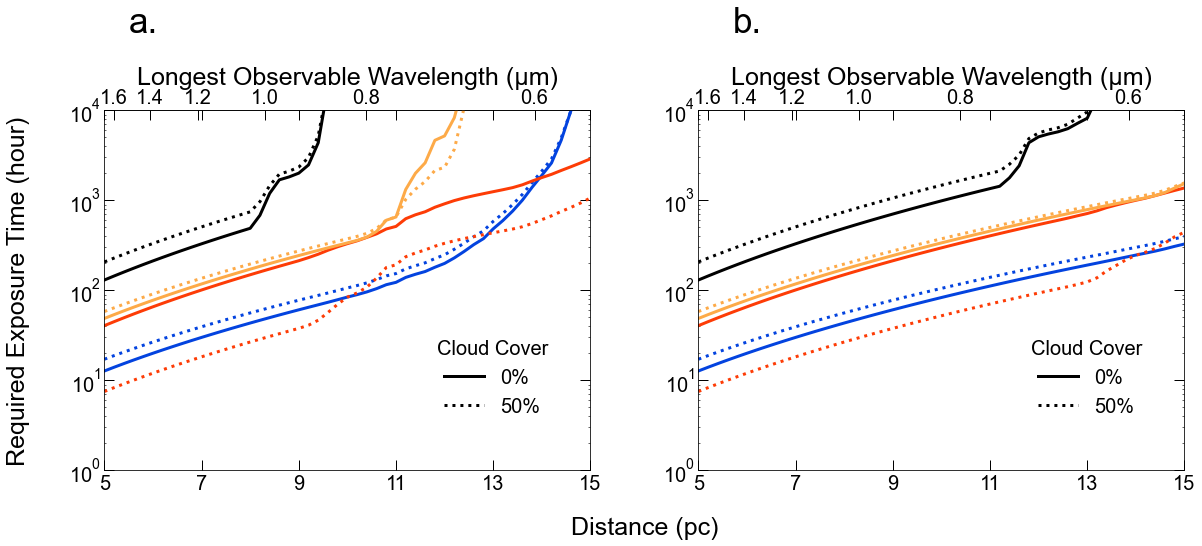

In [79]:
###################################################################################
# PLOTTING DT VS DISTANCES WITHOUT WAVELENGTH
###################################################################################

IWA_full = ascii.read("DetectionTimes_with_distances_def.txt", data_start=0,  delimiter='\s')
IWA_half = ascii.read('DetectionTimes_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

distance = IWA_full[0:51]['col3']
Arthro_0 = IWA_full[0:51]['col4']
Arthro_50 = IWA_full[104:155]['col4']
Ecto_0 = IWA_full[208:259]['col4']
Ecto_50 = IWA_full[312:363]['col4']
Black_0 = IWA_full[416:467]['col4']
Black_50 = IWA_full[520:571]['col4']
Orange_0 = IWA_full[624:675]['col4']
Orange_50 = IWA_full[728:779]['col4']

Arthro2_0 = IWA_half[0:51]['col4']
Arthro2_50 = IWA_half[104:155]['col4']
Ecto2_0 = IWA_half[208:259]['col4']
Ecto2_50 = IWA_half[312:363]['col4']
Black2_0 = IWA_half[416:467]['col4']
Black2_50 = IWA_half[520:571]['col4']
Orange2_0 = IWA_half[624:675]['col4']
Orange2_50 = IWA_half[728:779]['col4']

    
font = {'fontname':'Arial'}

legparams = font_manager.FontProperties(family = 'Arial', size = 20)

fig = plt.figure(facecolor='white', figsize=(15,5))
fig.supxlabel('Distance (pc)', fontsize = 25, **font, x=0.5, y=-0.19)
fig.supylabel('Required Exposure Time (hour)', fontsize = 25, **font,  x=-0.09, y=0.5)

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=0.45, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax0 = fig.add_subplot(gs1[0, 0])
ax0.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax0.plot(distance, Arthro_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Ecto_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax0.plot(distance, Black_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax0.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Orange_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax0.set_title('a.', fontsize = 35, **font, x = 0.08, y = 1.2)
ax0.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax0.set_xticks(np.arange(5, 16, step=2))
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
    
def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax0.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
ax0.set_yscale("log")
ax0.set_xlim(5, 15)
ax0.set_ylim(bottom = 1, top = 10e3)
l1 = ax0.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1), frameon=False)
l1.set_title(title = 'Cloud Cover', prop = legparams)
ax0.plot()




gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.55, right=1.0, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs2[0,0])
ax1.plot(distance, Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax1.plot(distance, Arthro2_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Ecto2_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax1.plot(distance, Black2_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax1.plot(distance, Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Orange2_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax1.set_title('b.', fontsize = 35, **font, x = 0.1, y = 1.2)
ax1.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax1.set_xticks(np.arange(5, 16, step=2))
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
    
secax = ax1.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, y=8)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
plt.xticks(np.arange(5, 16, step=2))  # Set label locations.
# Set the font name for axis tick labels to be Arial
ax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")
    
ax1.set_yscale("log")
ax1.set_xlim(5, 15)
ax1.set_ylim(bottom = 1, top = 10e3)
l2 = ax1.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1) , frameon=False)
l2.set_title(title = 'Cloud Cover', prop = legparams)
ax1.plot()



[]

/var/folders/0m/p68ndc2s0xn27djsm1tmz61c0000gn/T/ipykernel_33612/657319119.py:61: RuntimeWarning: divide by zero encountered in true_divide
  return 8.31 / ds


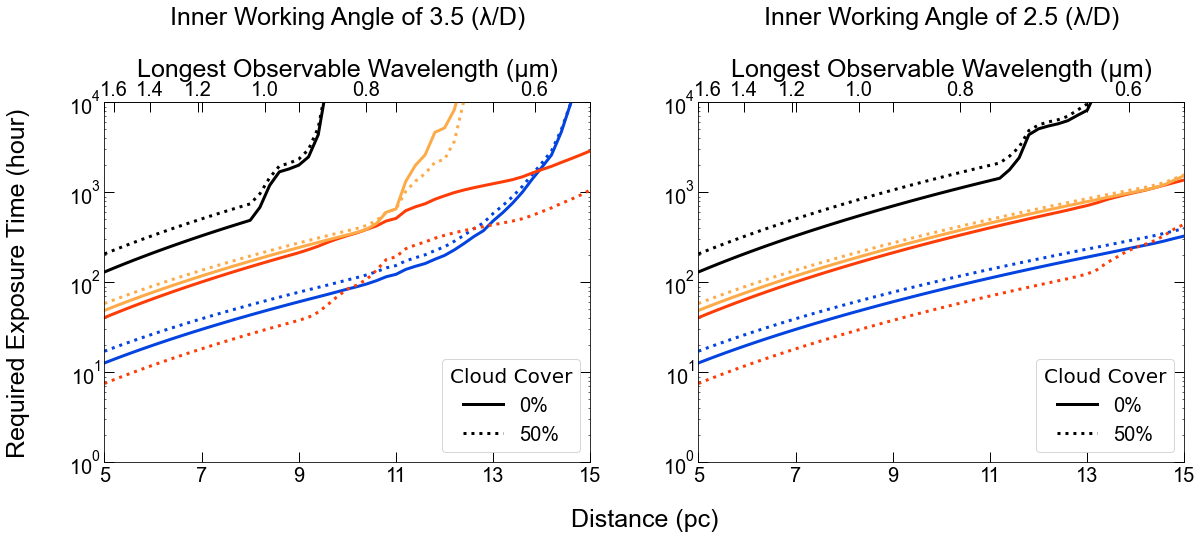

In [3]:
###################################################################################
# PLOTTING DT VS DISTANCES FOR IWA of 3.5 AND 1.75 WITH WAVELENGTH
###################################################################################

IWA_full = ascii.read("DetectionTimes_with_distances_def.txt", data_start=0,  delimiter='\s')
IWA_half = ascii.read('DetectionTimes_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

distance = IWA_full[0:51]['col3']
Arthro_0 = IWA_full[0:51]['col4']
Arthro_50 = IWA_full[104:155]['col4']
Ecto_0 = IWA_full[208:259]['col4']
Ecto_50 = IWA_full[312:363]['col4']
Black_0 = IWA_full[416:467]['col4']
Black_50 = IWA_full[520:571]['col4']
Orange_0 = IWA_full[624:675]['col4']
Orange_50 = IWA_full[728:779]['col4']

Arthro2_0 = IWA_half[0:51]['col4']
Arthro2_50 = IWA_half[104:155]['col4']
Ecto2_0 = IWA_half[208:259]['col4']
Ecto2_50 = IWA_half[312:363]['col4']
Black2_0 = IWA_half[416:467]['col4']
Black2_50 = IWA_half[520:571]['col4']
Orange2_0 = IWA_half[624:675]['col4']
Orange2_50 = IWA_half[728:779]['col4']

    
font = {'fontname':'Arial'}

legparams = font_manager.FontProperties(family = 'Arial', size = 20)

fig = plt.figure(facecolor='white', figsize=(15,5))
fig.supxlabel('Distance (pc)', fontsize = 25, **font, x=0.5, y=-0.19)
fig.supylabel('Required Exposure Time (hour)', fontsize = 25, **font,  x=-0.09, y=0.5)

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=0.45, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax0 = fig.add_subplot(gs1[0, 0])
ax0.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax0.plot(distance, Arthro_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Ecto_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax0.plot(distance, Black_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax0.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Orange_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax0.set_title('Inner Working Angle of 3.5 (\u03BB/D)', fontsize = 25, **font, y=1.2)
ax0.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax0.set_xticks(np.arange(5, 16, step=2))
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")

# Wavelength as second x-axis
def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds

secax = ax0.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
# Set the font name for axis tick labels to be Arial
ax0.set_yscale("log")
ax0.set_xlim(5, 15)
ax0.set_ylim(bottom = 1, top = 10e3)
ax0.legend(title_fontsize = 20, title = 'Cloud Cover', loc='lower right', prop = legparams)
ax0.plot()




gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.55, right=1.0, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs2[0,0])
ax1.plot(distance, Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax1.plot(distance, Arthro2_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Ecto2_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax1.plot(distance, Black2_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax1.plot(distance, Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Orange2_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax1.set_title('Inner Working Angle of 2.5 (\u03BB/D)', fontsize = 25, **font, y=1.2)
ax1.tick_params(axis='both', direction='in', length=10, width=1, labelsize=20)
ax1.set_xticks(np.arange(5, 16, step=2))
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")


# Wavelength as second x-axis
secax = ax1.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font)
secax.tick_params(axis='both', direction='in',length=10, width=1, labelsize=20)
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")
ax1.set_yscale("log")
ax1.set_xlim(5, 15)
ax1.set_ylim(bottom = 1, top = 10e3)
ax1.legend(title = 'Cloud Cover', title_fontsize = 20, loc = 'lower right', prop = legparams)
ax1.plot()


/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide


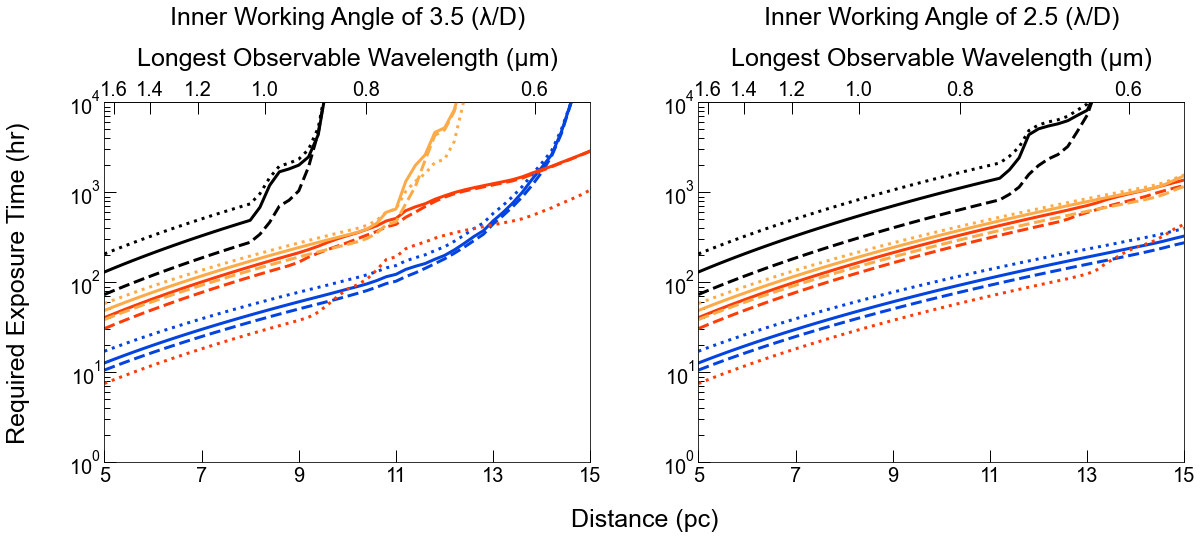

In [65]:
###################################################################################
# PLOTTING DT VS DISTANCES WITHOUT WAVELENGTH
###################################################################################

IWA_full = ascii.read("DetectionTimes_with_distances_def.txt", data_start=0,  delimiter='\s')
IWA_half = ascii.read('DetectionTimes_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

distance = IWA_full[0:51]['col3']
Arthro_0 = IWA_full[0:51]['col4']
Arthro_50 = IWA_full[104:155]['col4']
Ecto_0 = IWA_full[208:259]['col4']
Ecto_50 = IWA_full[312:363]['col4']
Black_0 = IWA_full[416:467]['col4']
Black_50 = IWA_full[520:571]['col4']
Orange_0 = IWA_full[624:675]['col4']
Orange_50 = IWA_full[728:779]['col4']

Arthro2_0 = IWA_half[0:51]['col4']
Arthro2_50 = IWA_half[104:155]['col4']
Ecto2_0 = IWA_half[208:259]['col4']
Ecto2_50 = IWA_half[312:363]['col4']
Black2_0 = IWA_half[416:467]['col4']
Black2_50 = IWA_half[520:571]['col4']
Orange2_0 = IWA_half[624:675]['col4']
Orange2_50 = IWA_half[728:779]['col4']

    
font = {'fontname':'Arial'}

legparams = font_manager.FontProperties(family = 'Arial', size = 20)

fig = plt.figure(facecolor='white', figsize=(15,5))
fig.supxlabel('Distance (pc)', fontsize = 25, **font, x=0.5, y=-0.19)
fig.supylabel('Required Exposure Time (hr)', fontsize = 25, **font,  x=-0.09, y=0.5)

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=0.45, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax0 = fig.add_subplot(gs1[0, 0])
ax0.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax0.plot(distance, Arthro_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Ecto_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax0.plot(distance, Black_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax0.plot(distance, Dry_Black_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = '_Dry Atm.')
ax0.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Orange_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax0.set_title('Inner Working Angle of 3.5 (\u03BB/D)', fontsize = 25, **font, y = 1.2)
ax0.tick_params(axis='both', direction='in', length=12, width=1, labelsize=20)
ax0.set_xticks(np.arange(5, 16, step=2))
ax0.xaxis.set_ticks_position("bottom")
ax0.xaxis.set_label_position("bottom")
ax0.yaxis.set_ticks_position("left")
ax0.yaxis.set_label_position("left")
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
ax0.tick_params(axis='y', which='minor', direction='in',length=6, width=1)
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
    
def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax0.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, labelpad=15)
secax.tick_params(axis='x', direction='in',length=12, width=1, labelsize=20)
secax.set_xticks(np.arange(0, 2.0, step=0.2))
secax.xaxis.set_ticks_position("top")
secax.xaxis.set_label_position("top")
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")

    
ax0.set_yscale("log")
ax0.set_xlim(5, 15)
ax0.set_ylim(bottom = 1, top = 10e3)
#l1 = ax0.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1), frameon=False)
#l1.set_title(title = 'Cloud Cover', prop = legparams)
ax0.plot()




gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.55, right=1.0, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs2[0,0])
ax1.plot(distance, Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax1.plot(distance, Arthro2_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Ecto2_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Earth at 0%')
ax1.plot(distance, Dry_Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = 'Dry at 0%')
ax1.plot(distance, Black2_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = 'Earth at 50%')
ax1.plot(distance, Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Orange2_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax1.set_title('Inner Working Angle of 2.5 (\u03BB/D)', fontsize = 25, **font, y = 1.2)
ax1.tick_params(axis='both', direction='in', length=12, width=1, labelsize=20)
ax1.set_xticks(np.arange(5, 16, step=2))
ax1.xaxis.set_ticks_position("bottom")
ax1.xaxis.set_label_position("bottom")
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.set_label_position("left")
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.tick_params(axis='y', which='minor', direction='in',length=6, width=1)
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
    
secax1 = ax1.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax1.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, labelpad=15)
secax1.tick_params(axis='x', direction='in',length=12, width=1, labelsize=20)
secax1.set_xticks(np.arange(0, 2.0, step=0.2))
secax1.xaxis.set_ticks_position("top")
secax1.xaxis.set_label_position("top")
for tick in secax1.get_xticklabels():
    tick.set_fontname("Arial")
    
    
ax1.set_yscale("log")
ax1.set_xlim(5, 15)
ax1.set_ylim(bottom = 1, top = 10e3)
#l2 = ax1.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1) , frameon=False)
#l2.set_title(title = 'Cloud Cover', prop = legparams)
ax1.plot()

plt.savefig('/Users/schuylerraeschroerborges/Downloads/Surface_biosignature_fig10.eps', format='eps')

/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in true_divide
/Users/schuylerraeschroerborges/anaconda3/envs/exo/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in true_divide


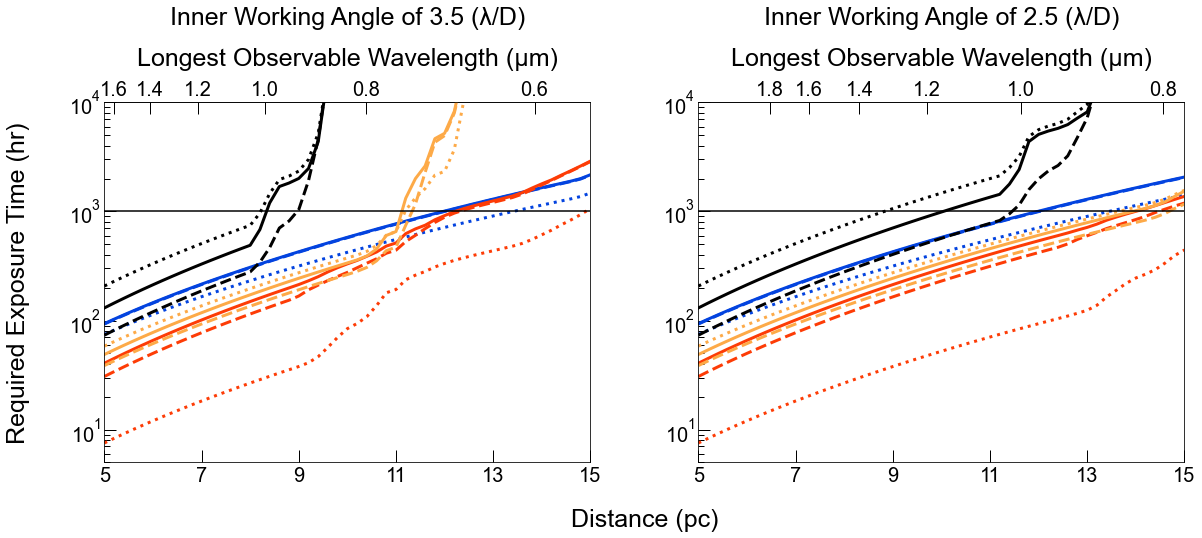

In [40]:
###################################################################################
# PLOTTING DT VS DISTANCES WITHOUT WAVELENGTH
###################################################################################

IWA_full = ascii.read("DetectionTimes_new_arthro_scrub_distances_IWA_3.5.txt", data_start=0,  delimiter='\s')
IWA_half = ascii.read('DetectionTimes_new_arthro_scrub_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

Dry_3 = ascii.read("Low_Water_DetectionTimes_new_arthro_scrub_distances_IWA_3.5.txt", data_start=0,  delimiter='\s')
Dry_2 = ascii.read('Low_Water_DetectionTimes_new_arthro_scrub_distances_IWA_2.5.txt', data_start = 0, delimiter = '\s')

distance = IWA_full[0:51]['col3']
Arthro_0 = IWA_full[0:51]['col4']
Arthro_50 = IWA_full[104:155]['col4']
Ecto_0 = IWA_full[208:259]['col4']
Ecto_50 = IWA_full[312:363]['col4']
Black_0 = IWA_full[416:467]['col4']
Black_50 = IWA_full[520:571]['col4']
Orange_0 = IWA_full[624:675]['col4']
Orange_50 = IWA_full[728:779]['col4']

Arthro2_0 = IWA_half[0:51]['col4']
Arthro2_50 = IWA_half[104:155]['col4']
Ecto2_0 = IWA_half[208:259]['col4']
Ecto2_50 = IWA_half[312:363]['col4']
Black2_0 = IWA_half[416:467]['col4']
Black2_50 = IWA_half[520:571]['col4']
Orange2_0 = IWA_half[624:675]['col4']
Orange2_50 = IWA_half[728:779]['col4']


# Dry atmosphere
Dry_Arthro_0 = Dry_3[0:51]['col4']
Dry_Ecto_0 = Dry_3[52:103]['col4']
Dry_Black_0 = Dry_3[104:155]['col4']
Dry_Orange_0 = Dry_3[156:207]['col4']

Dry_Arthro2_0 = Dry_2[0:51]['col4']
Dry_Ecto2_0 = Dry_2[52:103]['col4']
Dry_Black2_0 = Dry_2[104:155]['col4']
Dry_Orange2_0 = Dry_2[156:207]['col4']


    
font = {'fontname':'Arial'}

legparams = font_manager.FontProperties(family = 'Arial', size = 20)

fig = plt.figure(facecolor='white', figsize=(15,5))
fig.supxlabel('Distance (pc)', fontsize = 25, **font, x=0.5, y=-0.19)
fig.supylabel('Required Exposure Time (hr)', fontsize = 25, **font,  x=-0.09, y=0.5)

gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.0, right=0.45, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax0 = fig.add_subplot(gs1[0, 0])
ax0.plot(distance, Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax0.plot(distance, Arthro_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Arthro_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Ecto_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Ecto_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax0.plot(distance, Black_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = '0%')
ax0.plot(distance, Black_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = '50%')
ax0.plot(distance, Dry_Black_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = '_Dry Atm.')
ax0.plot(distance, Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax0.plot(distance, Orange_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax0.plot(distance, Dry_Orange_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax0.set_title('Inner Working Angle of 3.5 (\u03BB/D)', fontsize = 25, **font, y = 1.2)
ax0.tick_params(axis='both', direction='in', length=12, width=1, labelsize=20)
ax0.axhline(y=10e2, color='xkcd:black', alpha=1)
ax0.set_xticks(np.arange(5, 16, step=2))
ax0.xaxis.set_ticks_position("bottom")
ax0.xaxis.set_label_position("bottom")
ax0.yaxis.set_ticks_position("left")
ax0.yaxis.set_label_position("left")
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
ax0.tick_params(axis='y', which='minor', direction='in',length=6, width=1)
for tick in ax0.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax0.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
    
def lam2dist(lamb):
    return 8.31 / lamb

def dist2lam(ds):
    return 8.31 / ds


secax = ax0.secondary_xaxis('top', functions=(lam2dist, dist2lam))
secax.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, labelpad=15)
secax.tick_params(axis='x', direction='in',length=12, width=1, labelsize=20)
secax.set_xticks(np.arange(0, 2.0, step=0.2))
secax.xaxis.set_ticks_position("top")
secax.xaxis.set_label_position("top")
for tick in secax.get_xticklabels():
    tick.set_fontname("Arial")

    
ax0.set_yscale("log")
ax0.set_xlim(5, 15)
ax0.set_ylim(bottom = 5, top = 10e3)
#l1 = ax0.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1), frameon=False)
#l1.set_title(title = 'Cloud Cover', prop = legparams)
#ax0.plot()




gs2 = gridspec.GridSpec(1, 1)
gs2.update(left=0.55, right=1.0, bottom=0.0 , top=1., wspace=0, hspace=0.2)

ax1 = fig.add_subplot(gs2[0,0])
ax1.plot(distance, Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'solid')
ax1.plot(distance, Arthro2_50, c = 'xkcd:blue', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Arthro2_0, c = 'xkcd:blue', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Ecto2_50, c = 'xkcd:red orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Ecto2_0, c = 'xkcd:red orange', lw = 3.0, ls = 'dashed')
ax1.plot(distance, Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'solid', label = 'Earth at 0%')
ax1.plot(distance, Dry_Black2_0, c = 'xkcd:black', lw = 3.0, ls = 'dashed', label = 'Dry at 0%')
ax1.plot(distance, Black2_50, c = 'xkcd:black', lw = 3.0, ls = 'dotted', label = 'Earth at 50%')
ax1.plot(distance, Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'solid')
ax1.plot(distance, Orange2_50, c = 'xkcd:light orange', lw = 3.0, ls = 'dotted')
ax1.plot(distance, Dry_Orange2_0, c = 'xkcd:light orange', lw = 3.0, ls = 'dashed')
ax1.set_title('Inner Working Angle of 2.5 (\u03BB/D)', fontsize = 25, **font, y = 1.2)
ax1.tick_params(axis='both', direction='in', length=12, width=1, labelsize=20)
ax1.axhline(y=10e2, color='xkcd:black', alpha=1)
ax1.set_xticks(np.arange(5, 16, step=2))
ax1.xaxis.set_ticks_position("bottom")
ax1.xaxis.set_label_position("bottom")
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.set_label_position("left")
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.tick_params(axis='y', which='minor', direction='in',length=6, width=1)
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
legparams = font_manager.FontProperties(family = 'Arial', size = 25)
    
# lambda = D/2.5 x sep
# sep (arcsec) = (1 au) / (d pc)
# sep (radians) = (1 au) / (d pc) x 1/206265
# lambda (micrometers) = (D meters)/2.5 x 1e6 x (1 au)/(d pc) x 1/206265
# D meters = 6
# lambda (micrometers) = 11.64 / (d pc)

def lam2dist2(lamb2):
    return 11.64 / lamb2

def dist2lam2(ds2):
    return 11.64 / ds2


secax1 = ax1.secondary_xaxis('top', functions=(lam2dist2, dist2lam2))
secax1.set_xlabel(r'Longest Observable Wavelength (' + u'\u03bc' + 'm)', fontsize = 25, **font, labelpad=15)
secax1.tick_params(axis='x', direction='in',length=12, width=1, labelsize=20)
secax1.set_xticks(np.arange(0, 2.0, step=0.2))
secax1.xaxis.set_ticks_position("top")
secax1.xaxis.set_label_position("top")
for tick in secax1.get_xticklabels():
    tick.set_fontname("Arial")
    
    
ax1.set_yscale("log")
ax1.set_xlim(5, 15)
ax1.set_ylim(bottom = 5, top = 10e3)
#l2 = ax1.legend(title_fontsize = 20, prop = legparams, loc='lower right', bbox_to_anchor=(0.95, 0.1) , frameon=False)
#l2.set_title(title = 'Cloud Cover', prop = legparams)
#ax1.plot()

plt.savefig('/Users/schuylerraeschroerborges/Downloads/Figure10_test.tif', format='tif', bbox_inches="tight")